## **[3 Ways to Deal with Heteroskedasticity in Time Series](https://towardsdatascience.com/3-ways-to-deal-with-heteroskedasticity-in-time-series-831f6499e688)**
#### **How to stabilize the variance of time series and improve forecasting performance**

I describe how to detect heteroskedasticity in time series.

We continue to study the issue of non-constant variance here. You’ll learn three approaches used to deal with this condition.

### **Impact of Non-constant Variance**

Time series with non-constant variance often have a long-tailed distribution. The data is left- or right-skewed. This can impair the learning process of some algorithms. Methods such as deep neural networks are affected by this issue, unlike tree-based approaches.

The estimated coefficients of a linear model will still be unbiased. This means that they will be correct, on average. But, they won’t be the most precise.

Heteroskedasticity also invalidates any statistical test that assumes a constant variance among observations.

All in all, you’ll leave performance on the table by not dealing with heteroskedasticity.



### **How to Deal with Heteroskedasticity**

Suppose you ran a statistical test that confirms the time series is heteroskedastic.

What can you do about that?

Let’s look at three possible approaches.

#### **1. Log or Power Transformations**
Transforming the data is the go-to approach to remove heteroskedasticity. The goal is to stabilize the variance and to bring the distribution closer to the Normal distribution.

The log is an effective transformation to do this. Taking the square root or cubic root are two possible alternatives. These are particular instances of Box-Cox transformations.

Here’s how to apply Box-Cox to a time series using Python:

In [1]:
import numpy as np
from pmdarima.datasets import load_airpassengers
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# loading the data
series = load_airpassengers(True)

# transforming the series
# lambda_ is the transformation parameter
series_transformed, lambda_ = boxcox(series)

# reverting to the original scale
original_series = inv_boxcox(series_transformed, lambda_)

# check if it is the same as the original data
np.allclose(original_series, series)
# True

True

Box-Cox relies on a transformation parameter lambda. But, it is optimized under the hood by `scipy` automatically. No need to worry about that. When the value of lambda is equal to 0, applying the Box-Cox transformation is the same as log scaling.

You can use the function `inv_boxcox` to revert the transformed data to its original scale.

**_One limitation of Box-Cox is that it is only defined for positive data._** The _Yeo-Johnson transformation is like the Box-Cox method and addresses this problem._

Here’s the impact of Box-Cox in the example time series used in the script.

<center> <p>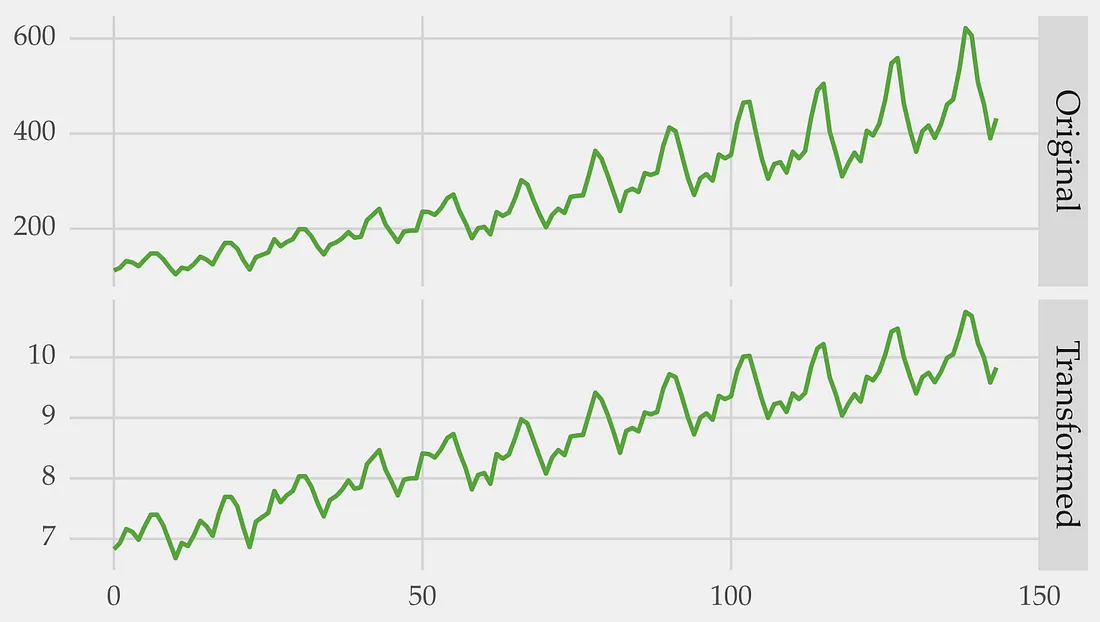</p> </center>

#### **2. Volatility Standardization**
Volatility standardization is another way to deal with non-constant variance.

The volatility of a time series is the recent level of variability in the data. This variability is often quantified with standard deviation. The idea of volatility standardization is to normalize the series based on its volatility. It leads to observations with the same level of variation.

Volatility standardization can be especially useful in data sets with many time series. For example, when training global forecasting models.

**Example**  

Let’s look at an example using a multivariate time series.

The goal is to forecast the future values of different variables in the series. We’ll use a global forecasting model to do this. You can learn more about global forecasting models in this introductory article. The basic idea is to build a single forecasting model using several time series as input.

The data set in this example is the wine sales time series. Here’s what it looks like:

<center> <p>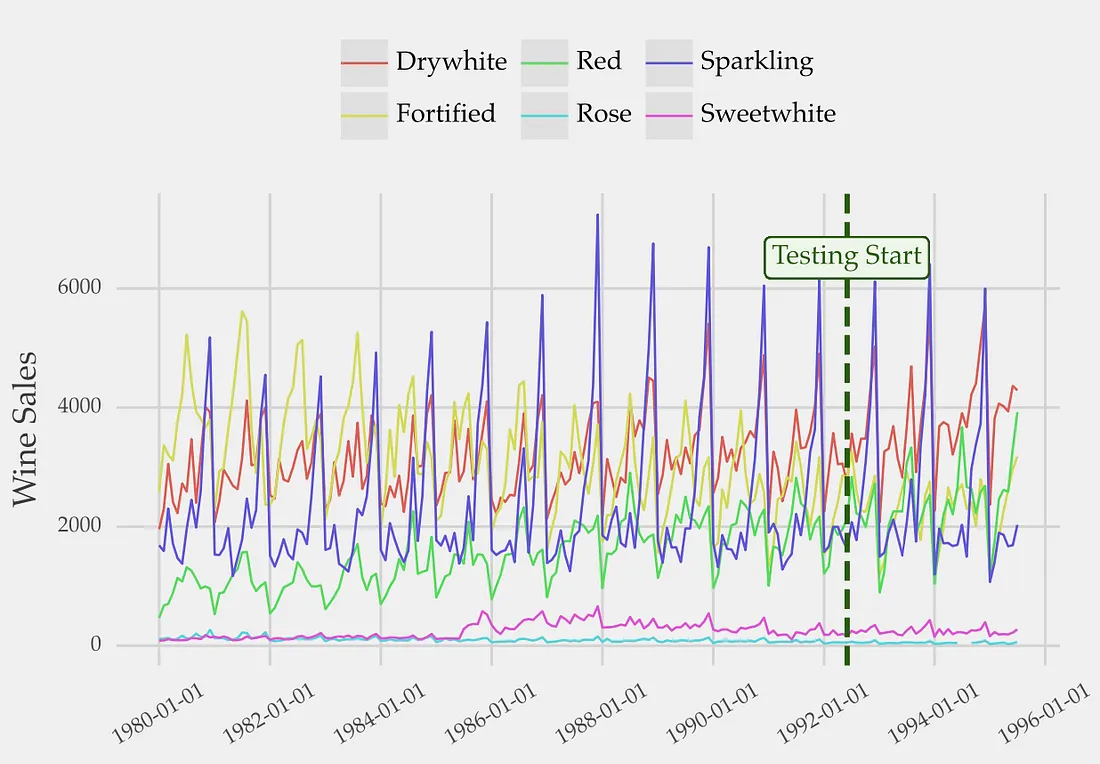</p> </center>

Within each variable (wine type), the variance looks stable over the series. But, it’s clear that different variables have a distinct level of variability. Volatility standardization can be used to stabilize the variance across each variable.

Here’s how to apply volatility standardization when building a forecasting model. Check the comments for more context.

In [3]:
import sys
sys.path.insert(0, '../')

import re
import numpy as np
import pandas as pd

# using xgboost as the regression algorithm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae

# https://github.com/vcerqueira/blog/
from src.tde import time_delay_embedding

# https://github.com/vcerqueira/blog/tree/main/data
wine = pd.read_csv('../data/wine_sales.csv', parse_dates=['date'])
wine.set_index('date', inplace=True)

# train test split
# using the last 20% of data as testing
train, test = train_test_split(wine, test_size=0.2, shuffle=False)

# transforming the time series for supervised learning
train_df, test_df = [], []
for col in wine:
    # using 12 lags to forecast the next value (horizon=1)
    col_train_df = time_delay_embedding(train[col], n_lags=12, horizon=1)
    col_train_df = col_train_df.rename(columns=lambda x: re.sub(col, 'Series', x))
    train_df.append(col_train_df)

    col_test_df = time_delay_embedding(test[col], n_lags=12, horizon=1)
    col_test_df = col_test_df.rename(columns=lambda x: re.sub(col, 'Series', x))
    test_df.append(col_test_df)

# different series are concatenated on rows
# to train a global forecasting model
train_df = pd.concat(train_df, axis=0)
test_df = pd.concat(test_df, axis=0)

# splitting the explanatory variables from target variables
predictor_variables = train_df.columns.str.contains('\(t\-')
target_variables = train_df.columns.str.contains('Series\(t\+')
X_train = train_df.iloc[:, predictor_variables]
Y_train = train_df.iloc[:, target_variables]
X_test = test_df.iloc[:, predictor_variables]
Y_test = test_df.iloc[:, target_variables]

# volatility standardization
# dividing by the standard deviation of past 12 lags
X_train_vs = X_train.apply(lambda x: x / x.std(), axis=0)
X_test_vs = X_test.apply(lambda x: x / x.std(), axis=0)

# testing three methods
## no normalization/preprocessing
mod_raw = XGBRegressor()
## volatility standardization
mod_vs = XGBRegressor()
## log transformation
mod_log = XGBRegressor()

# fitting on raw data
mod_raw.fit(X_train, Y_train)
# fitting with log-scaled data
mod_log.fit(np.log(X_train), np.log(Y_train))
# fitting with vol. std. data
mod_vs.fit(X_train_vs, Y_train)

# making predictions
preds_raw = mod_raw.predict(X_test)
preds_log = np.exp(mod_log.predict(np.log(X_test)))
preds_vs = mod_vs.predict(X_test_vs)

print(mae(Y_test, preds_raw))
# 301.73
print(mae(Y_test, preds_vs))
# 294.74
print(mae(Y_test, preds_log))
# 308.41

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_73064\4125449630.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wine = pd.read_csv('../data/wine_sales.csv', parse_dates=['date'])


298.81932134561606
286.3100381597772
324.5171604556637


Preprocessing the data with volatility standardization improves forecasting performance. Volatility standardization is also better relative to the log transformation in this problem.

#### **3. Weighted Regression**

Another way to cope with heteroskedasticity is to select an appropriate method. For example, one that doesn’t assume equal variance among observations.

You can also assign weights to observations based on their variability. By default, learning algorithms give equal weight to all observations in a data set. Yet, cases with higher variability have less information. You can decrease their importance to a method by reducing their weight.

These weights are computed according to the variance of the fitted values. A larger variance leads to a smaller weight. Here’s an [example](https://www.statsmodels.org/dev/examples/notebooks/generated/wls.html) from the statsmodels Python library.

Several algorithms in scikit-learn have a sample_weight parameter that you can use to set the weights.

### **Modeling the Variance**

You can model changes in the variance instead of stabilizing it.

This can be done with models such as ARCH (Auto-Regressive Conditional Heteroskedastic). This type of model is used to forecast the variance based on the past values of the time series.

GARCH (Generalized Auto-Regressive Conditional Heteroskedastic) extends ARCH. Besides using the past values of the series, it also uses past variances.

The [arch](https://pypi.org/project/arch/) library provides a Python implementation for these methods.

### **Take Aways**

In this article, you learned how to deal with heteroskedasticity in time series. We covered three approaches:

1. Log or power transformations;
2. Volatility standardization;
3. Weighted regression.

My personal preference is to transform the data. I go for option 1 when I’m dealing with a single time series. For several time series, I tend to use option 2. But, this is something you can optimize using cross-validation.

You can model the variance directly using ARCH/GARCH methods.

Thank you for reading and see you in the next story!